In [1]:
import pandas as pd
import numpy as np
from sklearn import model_selection, preprocessing
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import sys

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if torch.cuda.is_available():
    print("✅ CUDA is available. Using GPU.")
else:
    print("⚠️ CUDA is not available. Using CPU instead.")

✅ CUDA is available. Using GPU.


In [3]:
# # Load the MovieLens 100k dataset
# path = "ml-100k/"  # Update this path to the location of your MovieLens 100k data

# # Ratings
# df = pd.read_csv(path + 'u.data', sep='\t', header=None, encoding='latin-1')
# df.columns = ['userId', 'movieId', 'rating', 'timestamp']

#Load data
path = "ml-1m/"

#Ratings
df = pd.read_csv(path+'ratings.dat', sep='::', header=None, encoding='latin-1', engine='python')
df.columns = ['userId','movieId','rating','timestamp']



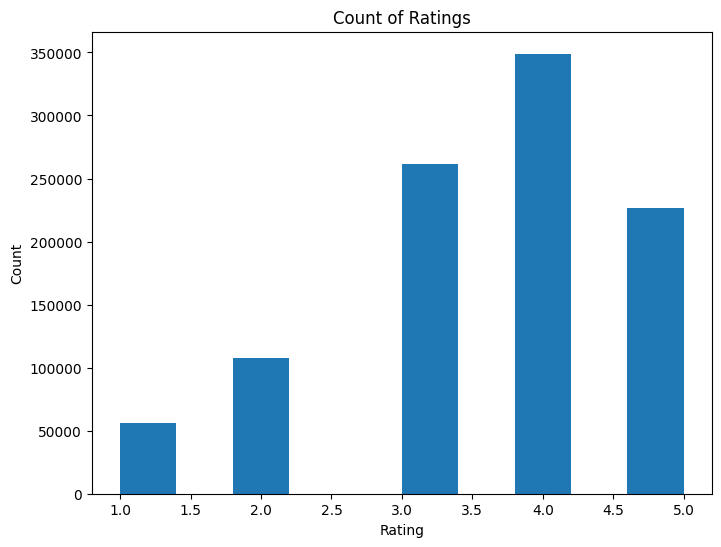

In [4]:
plt.figure(figsize=(8, 6))
plt.hist(df.rating)
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Count of Ratings")
plt.show()

In [5]:
class MovieLensDataset(Dataset):
    """
    The Movie Lens Dataset class. This class prepares the dataset for training and validation.
    """
    def __init__(self, users, movies, ratings):
        """
        Initializes the dataset object with user, movie, and rating data.
        """
        self.users = users
        self.movies = movies
        self.ratings = ratings

    def __len__(self):
        """
        Returns the total number of samples in the dataset.
        """
        return len(self.users)

    def __getitem__(self, item):
        """
        Retrieves a sample from the dataset at the specified index.
        """
        users = self.users[item]
        movies = self.movies[item]
        ratings = self.ratings[item]

        return {
            "users": torch.tensor(users, dtype=torch.long),
            "movies": torch.tensor(movies, dtype=torch.long),
            "ratings": torch.tensor(ratings, dtype=torch.float),
        }

In [6]:
class RecommendationSystemModel(nn.Module):
    def __init__(
        self,
        num_users,
        num_movies,
        embedding_size=256,
        hidden_dim=256,
        dropout_rate=0.2,
    ):
        super(RecommendationSystemModel, self).__init__()
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.hidden_dim = hidden_dim

        # Embedding layers
        self.user_embedding = nn.Embedding(
            num_embeddings=self.num_users, embedding_dim=self.embedding_size
        )
        self.movie_embedding = nn.Embedding(
            num_embeddings=self.num_movies, embedding_dim=self.embedding_size
        )

        # Hidden layers
        self.fc1 = nn.Linear(2 * self.embedding_size, self.hidden_dim)
        self.fc2 = nn.Linear(self.hidden_dim, 1)

        # Dropout layer
        self.dropout = nn.Dropout(p=dropout_rate)

        # Activation function
        self.relu = nn.ReLU()

    def forward(self, users, movies):
        # Embeddings
        user_embedded = self.user_embedding(users)
        movie_embedded = self.movie_embedding(movies)

        # Concatenate user and movie embeddings
        combined = torch.cat([user_embedded, movie_embedded], dim=1)

        # Pass through hidden layers with ReLU activation and dropout
        x = self.relu(self.fc1(combined))
        x = self.dropout(x)
        output = self.fc2(x)

        return output

In [7]:
le_user = preprocessing.LabelEncoder()
le_movie = preprocessing.LabelEncoder()
df.userId = le_user.fit_transform(df.userId.values)
df.movieId = le_movie.fit_transform(df.movieId.values)

df_train, df_val = model_selection.train_test_split(
    df, test_size=0.1, random_state=3, stratify=df.rating.values
)

train_dataset = MovieLensDataset(
    users=df_train.userId.values,
    movies=df_train.movieId.values,
    ratings=df_train.rating.values,
)

valid_dataset = MovieLensDataset(
    users=df_val.userId.values,
    movies=df_val.movieId.values,
    ratings=df_val.rating.values,
)

In [8]:
BATCH_SIZE = 32

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True
)
val_loader = DataLoader(
    valid_dataset, batch_size=BATCH_SIZE, shuffle=True
)

In [9]:
recommendation_model = RecommendationSystemModel(
    num_users=len(le_user.classes_),
    num_movies=len(le_movie.classes_),
    embedding_size=64,
    hidden_dim=128,
    dropout_rate=0.1,
).to(device)

optimizer = torch.optim.Adam(recommendation_model.parameters(), lr=1e-3)
loss_func = nn.MSELoss()

In [10]:
EPOCHS = 5


# Function to log progress
def log_progress(epoch, step, total_loss, log_progress_step, data_size, losses):
    avg_loss = total_loss / log_progress_step
    sys.stderr.write(
        f"\r{epoch+1:02d}/{EPOCHS:02d} | Step: {step}/{data_size} | Avg Loss: {avg_loss:<6.9f}"
    )
    sys.stderr.flush()
    losses.append(avg_loss)

In [87]:
total_loss = 0
log_progress_step = 100
losses = []
train_dataset_size = len(train_dataset)
print(f"Training on {train_dataset_size} samples...")

recommendation_model.train()
for e in range(EPOCHS):
    epoch_loss = 0  # To accumulate the total loss for the epoch
    step_count = 0  # Reset step count at the beginning of each epoch
    
    for i, train_data in enumerate(train_loader):
        output = recommendation_model(
            train_data["users"].to(device), train_data["movies"].to(device)
        )
        # Reshape the model output to match the target's shape
        output = output.squeeze()  # Removes the singleton dimension
        ratings = (
            train_data["ratings"].to(torch.float32).to(device)
        )  # Assuming ratings is already 1D

        loss = loss_func(output, ratings)
        batch_loss = loss.sum().item()
        total_loss += batch_loss
        epoch_loss += batch_loss  # Add to epoch's total loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Increment step count by the actual size of the batch
        step_count += len(train_data["users"])

        # Check if it's time to log progress
        if (
            step_count % log_progress_step == 0 or i == len(train_loader) - 1
        ):  # Log at the end of each epoch
            log_progress(
                e, step_count, total_loss, log_progress_step, train_dataset_size, losses
            )
            total_loss = 0

    # Calculate and print the average loss for the epoch
    avg_loss = epoch_loss / len(train_loader.dataset)
    print(f"Epoch {e + 1}/{EPOCHS}, Average Loss: {avg_loss:.4f}")
    losses.append(avg_loss)  # Store the average loss for this epoch


Training on 900188 samples...


01/05 | Step: 900188/900188 | Avg Loss: 0.044162108

Epoch 1/5, Average Loss: 0.0246


02/05 | Step: 900188/900188 | Avg Loss: 0.052613610

Epoch 2/5, Average Loss: 0.0240


03/05 | Step: 900188/900188 | Avg Loss: 0.051683721

Epoch 3/5, Average Loss: 0.0235


05/05 | Step: 800/900188 | Avg Loss: 0.174010237903

Epoch 4/5, Average Loss: 0.0231


05/05 | Step: 900188/900188 | Avg Loss: 0.043027021

Epoch 5/5, Average Loss: 0.0226


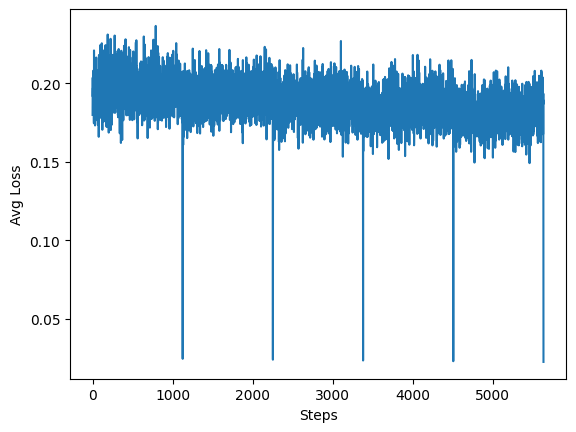

In [88]:
plt.figure()
plt.plot(losses)
plt.xlabel("Steps")
plt.ylabel("Avg Loss")
plt.show()

In [89]:
from sklearn.metrics import mean_squared_error

y_pred = []
y_true = []

recommendation_model.eval()

with torch.no_grad():
    for i, valid_data in enumerate(val_loader):
        output = recommendation_model(
            valid_data["users"].to(device), valid_data["movies"].to(device)
        )
        ratings = valid_data["ratings"].to(device)
        y_pred.extend(output.cpu().numpy())
        y_true.extend(ratings.cpu().numpy())

# Calculate RMSE
rms = mean_squared_error(y_true, y_pred, squared=False)
print(f"RMSE: {rms:.4f}")

RMSE: 0.8894


In [90]:
from collections import defaultdict


def calculate_precision_recall(user_ratings, k, threshold):
    user_ratings.sort(key=lambda x: x[0], reverse=True)
    n_rel = sum(true_r >= threshold for _, true_r in user_ratings)
    n_rec_k = sum(est >= threshold for est, _ in user_ratings[:k])
    n_rel_and_rec_k = sum(
        (true_r >= threshold) and (est >= threshold) for est, true_r in user_ratings[:k]
    )

    precision = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1
    recall = n_rel_and_rec_k / n_rel if n_rel != 0 else 1
    return precision, recall


user_ratings_comparison = defaultdict(list)

with torch.no_grad():
    for valid_data in val_loader:
        users = valid_data["users"].to(device)
        movies = valid_data["movies"].to(device)
        ratings = valid_data["ratings"].to(device)
        output = recommendation_model(users, movies)

        for user, pred, true in zip(users, output, ratings):
            user_ratings_comparison[user.item()].append((pred[0].item(), true.item()))

user_precisions = dict()
user_based_recalls = dict()

k = 50
threshold = 3

for user_id, user_ratings in user_ratings_comparison.items():
    precision, recall = calculate_precision_recall(user_ratings, k, threshold)
    user_precisions[user_id] = precision
    user_based_recalls[user_id] = recall

In [15]:
average_precision = sum(prec for prec in user_precisions.values()) / len(
    user_precisions
)
average_recall = sum(rec for rec in user_based_recalls.values()) / len(
    user_based_recalls
)

print(f"precision @ {k}: {average_precision:.4f}")
print(f"recall @ {k}: {average_recall:.4f}")

precision @ 50: 0.9074
recall @ 50: 0.8997


In [60]:
def recommend_top_movies(model, user_id, all_movies, seen_movies, device, k=10, batch_size=100):
    model.eval()
    unseen_movies = [m for m in all_movies if m not in seen_movies]
    predictions = []

    # Predict ratings for unseen movies
    with torch.no_grad():
        for i in range(0, len(unseen_movies), batch_size):
            batch_unseen_movies = unseen_movies[i:i+batch_size]
            user_tensor = torch.tensor([user_id] * len(batch_unseen_movies)).to(device)
            movie_tensor = torch.tensor(batch_unseen_movies).to(device)
            predicted_ratings = model(user_tensor, movie_tensor).view(-1).tolist()
            predictions.extend(zip(batch_unseen_movies, predicted_ratings))

    predictions.sort(key=lambda x: x[1], reverse=True)
    
    # Get the top k movies with their predicted ratings
    top_k_movies_with_ratings = [(movie_id, rating) for movie_id, rating in predictions[:k]]
    
    return top_k_movies_with_ratings

def get_movies_with_genres(movie_ids, df_movies):
    # Select the relevant movies and create a new DataFrame
    movies_with_genres = df_movies[df_movies['movieId'].isin(movie_ids)].copy()
    
    # Ensure genres are in the right format and concatenate movie titles with their genres
    movies_with_genres['title_with_genres'] = movies_with_genres.apply(
        lambda row: f"{row['title']} - {' / '.join(str(genre) for genre in row['genres'].split('|'))}", axis=1
    )
    
    return movies_with_genres['title_with_genres'].tolist()

def get_seen_movies_with_ratings(user_id, df):
    # Filter movies that the user has seen and get their ratings
    user_seen_movies = df[df['userId'] == user_id][['movieId', 'rating']]
    return user_seen_movies


In [61]:


#Movies
df_movies = pd.read_csv(path+'movies.dat', sep='::', header=None, encoding='latin-1', engine='python')
df_movies.columns = ['movieId','title','genres']

# Handle potential NaN values in the 'genres' column
df_movies['genres'] = df_movies['genres'].fillna('')  # Replace NaN values with an empty string

# Split the genres properly
df_movies['genres'] = df_movies['genres'].apply(lambda x: x.split('|') if isinstance(x, str) else [])



In [62]:
df_movies

,movieId,title,genres
0,1,Toy Story (1995),"[Animation, Children's, Comedy]"
1,2,Jumanji (1995),"[Adventure, Children's, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama]"
4,5,Father of the Bride Part II (1995),[Comedy]
...,...,...,...
3878,3948,Meet the Parents (2000),[Comedy]
3879,3949,Requiem for a Dream (2000),[Drama]
3880,3950,Tigerland (2000),[Drama]
3881,3951,Two Family House (2000),[Drama]


In [63]:
# Prepare all_movies and seen_movies
all_movies = df['movieId'].unique().tolist()


In [94]:
user_id = 5258  # A random userId
seen_movies = set(df[df['userId'] == user_id]['movieId'].tolist())

In [93]:
len(seen_movies)

34

In [95]:
# Get recommendations
recommendations = recommend_top_movies(
    recommendation_model, user_id, all_movies, seen_movies, device
)

In [96]:
recommendations

[(1066, 5.2048139572143555),
 (1839, 5.02632474899292),
 (2005, 5.0041890144348145),
 (2809, 4.994767189025879),
 (2021, 4.953431606292725),
 (1162, 4.9197096824646),
 (1170, 4.9126176834106445),
 (1175, 4.88335657119751),
 (2167, 4.8801350593566895),
 (1129, 4.867081642150879)]

In [97]:
# Extract only the movie IDs from the recommendations (ignore the ratings)
recommended_movie_ids = [movie_id for movie_id, _ in recommendations]
predicted_ratings = [rating for _, rating in recommendations]


In [98]:
recommended_movie_ids

[1066, 1839, 2005, 2809, 2021, 1162, 1170, 1175, 2167, 1129]

In [99]:
# Get the rows for the recommended movie IDs
recommended_movies = df_movies[df_movies['movieId'].isin(recommended_movie_ids)]

# Merge the predicted ratings into the DataFrame
recommended_movies['predicted_rating'] = recommended_movies['movieId'].map(
    dict(zip(recommended_movie_ids, predicted_ratings))
)

# Select the relevant columns (title and genres)
recommended_movies_info = recommended_movies[['movieId', 'title', 'genres', 'predicted_rating']]

# Display the result
recommended_movies_info

C:\Users\bryan\AppData\Local\Temp\ipykernel_16380\3874772953.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommended_movies['predicted_rating'] = recommended_movies['movieId'].map(


,movieId,title,genres,predicted_rating
1052,1066,Shall We Dance? (1937),"[Comedy, Musical, Romance]",5.204814
1113,1129,Escape from New York (1981),"[Action, Adventure, Sci-Fi, Thriller]",4.867082
1146,1162,"Ruling Class, The (1972)",[Comedy],4.919710
1154,1170,Best of the Best 3: No Turning Back (1995),[Action],4.912618
1159,1175,Delicatessen (1991),"[Comedy, Sci-Fi]",4.883357
1770,1839,My Giant (1998),[Comedy],5.026325
1936,2005,"Goonies, The (1985)","[Adventure, Children's, Fantasy]",5.004189
1952,2021,Dune (1984),"[Fantasy, Sci-Fi]",4.953432
2098,2167,Blade (1998),"[Action, Adventure, Horror]",4.880135
2740,2809,Love Stinks (1999),[Comedy],4.994767


In [100]:
# Get all of the user's seen movies and sort by rating
seen_movies_df = df[df['userId'] == user_id].sort_values(by="rating", ascending=False)

# Merge with movie titles and genres from df_movies
seen_movies_info = pd.merge(seen_movies_df[['movieId', 'rating']], df_movies[['movieId', 'title', 'genres']], on='movieId')

# Create the final DataFrame with relevant columns for seen movies
seen_movies_info = pd.DataFrame({
    'movieId': seen_movies_info['movieId'],
    'title': seen_movies_info['title'],
    'genres': seen_movies_info['genres'],
    'rating': seen_movies_info['rating']
})

# Display the seen movies DataFrame
seen_movies_info.head(20)

,movieId,title,genres,rating
0,35,Carrington (1995),"[Drama, Romance]",5
1,1154,T-Men (1947),[Film-Noir],5
2,1117,"Eighth Day, The (Le Huitième jour ) (1996)",[Drama],5
3,1131,Jean de Florette (1986),[Drama],5
4,1772,Blues Brothers 2000 (1998),"[Action, Comedy, Musical]",5
5,1765,"Letter From Death Row, A (1998)","[Crime, Drama]",5
6,309,"Red Firecracker, Green Firecracker (1994)",[Drama],5
7,2651,Frankenstein Meets the Wolf Man (1943),[Horror],5
8,3223,"Zed & Two Noughts, A (1985)",[Drama],5
9,1155,"Invitation, The (Zaproszenie) (1986)",[Drama],5
